In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import os

In [2]:
nsims = 100
nside = 256
npix = hp.nside2npix(nside)
lmax = 3*nside-1

# Signal-only sims

[]

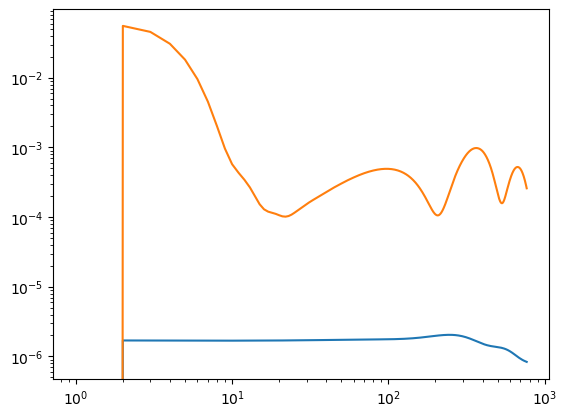

In [3]:
def read_cls():
    ls = np.arange(lmax+1)
    ll, dltt, dlee, dlbb, dlte = np.loadtxt("data/camb_lens_nobb.dat", unpack=True)
    dl2cl = 2*np.pi/(ll*(ll+1))
    cltt = np.zeros(lmax+1); cltt[2:] = (dl2cl*dltt)[1:lmax]
    clee = np.zeros(lmax+1); clee[2:] = (dl2cl*dlee)[1:lmax]
    clbb = np.zeros(lmax+1); clbb[2:] = (dl2cl*dlbb)[1:lmax]
    clte = np.zeros(lmax+1); clte[2:] = (dl2cl*dlte)[1:lmax]
    return ls, cltt, clee, clbb, clte


ls, cltt, clee, clbb, clte = read_cls()

plt.plot(ls, clbb)
plt.plot(ls, clee)
plt.loglog()

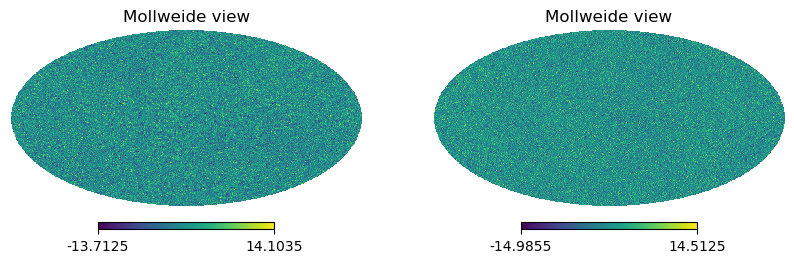

In [4]:
def get_cmb_sim():
    elm = hp.synalm(clee)
    blm = hp.synalm(clbb)
    q, u = hp.alm2map_spin([elm, blm], nside=nside, spin=2, lmax=lmax, mmax=lmax)
    return q, u

qq, uu = get_cmb_sim()
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.axes(axes[0]); hp.mollview(qq, hold=True)
plt.axes(axes[1]); hp.mollview(uu, hold=True)

In [5]:
dirname = "data/sims"
os.system(f"mkdir -p {dirname}")
for i in range(nsims):
    seed = 1000+i
    fname = f"{dirname}/sim_cmb_{seed}.fits"
    if os.path.isfile(fname):
        continue
    print(seed)
    np.random.seed(seed)
    q, u = get_cmb_sim()
    hp.write_map(fname, [q, u], overwrite=True)

[]

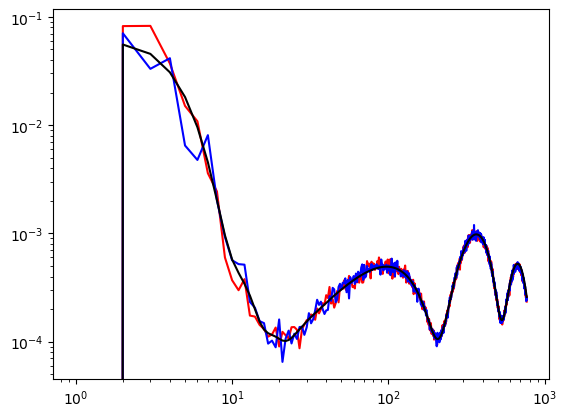

In [6]:
plt.figure()
qq, uu = get_cmb_sim()
_, ee, bb, _, eb, _ = hp.anafast([0*qq, qq, uu])
plt.plot(ls, ee, 'r-')
qq, uu = hp.read_map("data/sims/sim_cmb_1000.fits", field=None)
_, ee, bb, _, eb, _ = hp.anafast([0*qq, qq, uu])
plt.plot(ls, ee, 'b-')
plt.plot(ls, clee, 'k-')
plt.loglog()

# Noise-only sims

setting the output map dtype to [dtype('float32')]
/home/damonge/Science/SO/SOForeCasts/Curlicast/covariance_validation/noisecalc.py:219: RuntimeWarning: divide by zero encountered in scalar divide
  cov_weight[i,j] += ( tube_count * N_tels /


0.10030567


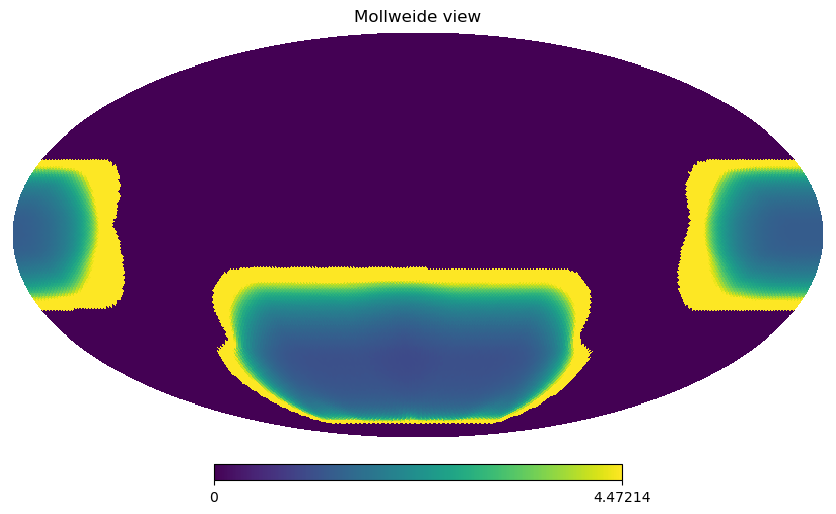

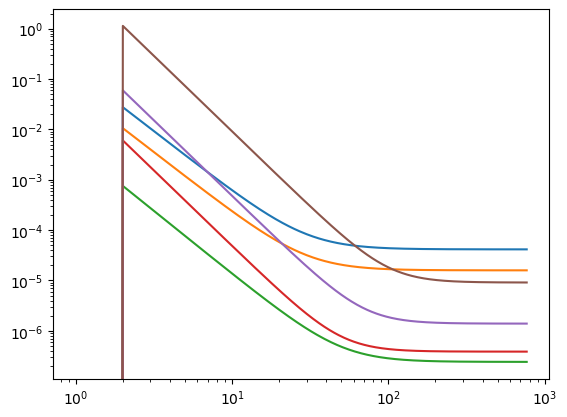

In [7]:
import noisecalc as nc

mask = hp.ud_grade(hp.read_map("data/mask_apodized.fits"), nside_out=nside)
mask_b = (mask > 0).astype(float)
nhits = hp.ud_grade(hp.read_map("data/nhits_SAT.fits"), nside_out=nside)
nhits[nhits < 1E-3] = 0
nhits[(nhits > 0) & (nhits < 0.05)] = 0.05
hp.write_map(f"data/nhits_ns{nside}.fits.gz", nhits, overwrite=True)
good = nhits > 0
inhom = np.zeros_like(nhits)
inhom[good] = 1/np.sqrt(nhits[good])
fsky = np.mean(nhits)
print(fsky)
hp.mollview(inhom)

ncal = nc.SOSatV3point1(sensitivity_mode='baseline',
                        N_tubes=[1, 9, 5],
                        one_over_f_mode=0)
ll, _, nl_from2 = ncal.get_noise_curves(f_sky=fsky, ell_max=lmax+1,
                                        delta_ell=1, deconv_beam=False)
nl = np.zeros([len(nl_from2), lmax+1])
nl[:, 2:] = nl_from2
nl_white = np.zeros_like(nl)
nl_white[:, :] = nl[:, -1].reshape([-1, 1])
plt.figure()
for n in nl:
    plt.plot(ls, n)
plt.loglog()
np.savez("data/nls.npz", ls=ls, nls=nl, nls_white=nl_white)

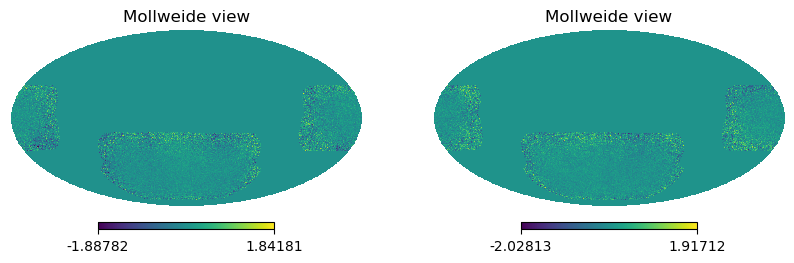

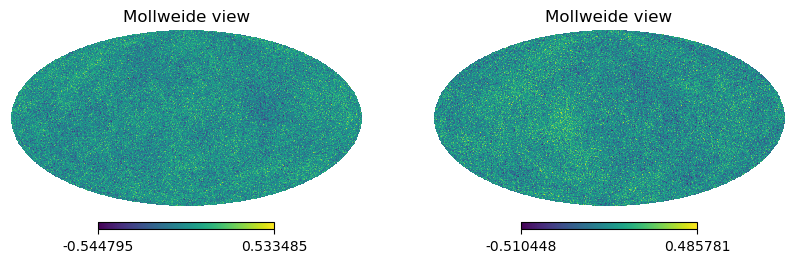

In [8]:
def get_noise_sim(band, white=False, flat=False):
    if white:
        cl = nl_white[band]
    else:
        cl = nl[band]
    elm = hp.synalm(cl)
    blm = hp.synalm(cl)
    q, u = hp.alm2map_spin([elm, blm], nside=nside, spin=2, lmax=lmax, mmax=lmax)
    if flat:
        return q, u
    return q*inhom, u*inhom

qq, uu = get_noise_sim(2)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.axes(axes[0]); hp.mollview(qq, hold=True)
plt.axes(axes[1]); hp.mollview(uu, hold=True)
qq, uu = get_noise_sim(2, flat=True)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plt.axes(axes[0]); hp.mollview(qq, hold=True)
plt.axes(axes[1]); hp.mollview(uu, hold=True)

In [9]:
for i in range(nsims):
    seed = 1000+i
    for band in [2]:
        fname = f"{dirname}/sim_noise_white_band{band}_{seed}.fits.gz"
        if os.path.isfile(fname):
            continue
        print(i, band)
        np.random.seed(seed+1000+band)
        q, u = get_noise_sim(band=band, white=True)
        hp.write_map(fname, [q, u], overwrite=True)
for i in range(nsims):
    seed = 1000+i
    for band in [2]:
        fname = f"{dirname}/sim_noise_red_band{band}_{seed}.fits.gz"
        if os.path.isfile(fname):
            continue
        print(i, band)
        np.random.seed(seed+1000+band)
        q, u = get_noise_sim(band=band, white=False)
        hp.write_map(fname, [q, u], overwrite=True)

In [10]:
for i in range(nsims):
    seed = 1000+i
    for band in [2]:
        fname = f"{dirname}/sim_noise_flat_white_band{band}_{seed}.fits.gz"
        if os.path.isfile(fname):
            continue
        print(i, band)
        np.random.seed(seed+1000+band)
        q, u = get_noise_sim(band=band, white=True, flat=True)
        hp.write_map(fname, [q, u], overwrite=True)
for i in range(nsims):
    seed = 1000+i
    for band in [2]:
        fname = f"{dirname}/sim_noise_flat_red_band{band}_{seed}.fits.gz"
        if os.path.isfile(fname):
            continue
        print(i, band)
        np.random.seed(seed+1000+band)
        q, u = get_noise_sim(band=band, white=False, flat=True)
        hp.write_map(fname, [q, u], overwrite=True)